In [1]:
import sys
sys.path.append('../../numpy/2D')

from utils import *
from env import *
from model import *
from matplotlib import gridspec

In [2]:
# set directory to folder with model trained with different place field parameter combinations
data_dir = "/Users/mganeshkumar/Library/CloudStorage/OneDrive-HarvardUniversity/Code/online_pf_learning/online/2D/"

In [3]:
load_expt = "/data/2D_obs_td_multi_0.0ns_012p_256n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_4a_2020s_50000e_5rmax_0.1rsz"

[logparams, latencys,cum_rewards, allcoords] = saveload(data_dir+load_expt, 1, 'load')

In [4]:
def predict_sr_batch_placecell(params, xs):  
    pcacts = []  
    for x in xs:
        pcacts.append(predict_sr_placecell(params, x))
    pcacts = np.array(pcacts)
    return pcacts

def predict_sr_placecell(params, x):
    pc_centers, pc_sigmas, pc_constant, actor_weights, critic_weights = params
    exponent = np.sum((x - pc_centers)**2 / (2*pc_sigmas ** 2),axis=1)
    pcacts = np.exp(-exponent) * pc_constant**2
    return pcacts


load_expt = "/data/2D_diag_obs_td_multi_0.0ba_0.0ns_012p_256n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_4a_2020s_50000e_5rmax_0.1rsz"
[sr_logparams, sr_latencys,sr_cum_rewards, sr_allcoords] = saveload(data_dir+load_expt, 1, 'load')

sr_expt = "./data/2D_some_sr_0.0025_2D_diag_obs_td_multi_0.0ba_0.0ns_012p_256n_0.01plr_0.01clr_0.0llr_0.0alr_0.0slr_uni_4a_2020s_50000e_5rmax_0.1rsz"
[Us] = saveload(data_dir+sr_expt,1, 'load')

xs = get_statespace(41)
ca3 = predict_sr_batch_placecell(sr_logparams[0], xs)

In [5]:
def plot_trajectory(allcoords,trial, obs=True, goalcoord=[0.75,-0.75],goalsize=0.05, ax=None):
    if ax is None:
        f,ax = plt.subplots()

    if obs:
        ax.add_patch(Rectangle((-0.2,0.5), 0.4, -1.5, facecolor='grey'))  # top left

    trail = np.array(allcoords[trial-1])
    
    ax.plot(trail[1:,0],trail[1:,1], marker='o',color='b', zorder=1)
    circle = plt.Circle(xy=goalcoord, radius=goalsize*2, color='r',zorder=2)
    ax.add_patch(circle)
    # ax.scatter(trail[1,0],trail[1,1], color='g', zorder=2)    
    circle = plt.Circle(xy=trail[1,:], radius=goalsize, color='g',zorder=2)
    ax.add_patch(circle)
    ax.axis([-1, 1,-1, 1])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlabel('$x_1$')
    # ax.set_ylabel('$x_2$')

def plot_pc(logparams, trial,pi=None,title='',  ax=None, goalcoord=[0.75,-0.75], startcoord=[-0.75,-0.75], goalsize=0.05, envsize=1, obs=True):
    if ax is None:
        f,ax = plt.subplots()
    
    num = 41
    xs = get_statespace(num)
    pcacts = predict_batch_placecell(logparams[trial], xs)
    
    if pi is None:
        pi = np.argmax(np.mean(pcacts,axis=0))
    
    max_value = np.max(pcacts[:,pi])
    ax.imshow(pcacts[:, pi].reshape(num, num), origin='lower', extent=[-envsize, envsize, -envsize, envsize], 
              vmin=0, vmax=max_value)

    start_radius = 0.05
    start_circle = plt.Circle(startcoord, start_radius, color='green', fill=True)
    ax.add_artist(start_circle)

    num_circles = 2
    for i in range(num_circles):
        radius = goalsize * (num_circles - i) / num_circles
        color = (1, i/num_circles, i/num_circles)  # RGB tuple for gradient from white to red
        circle = plt.Circle(goalcoord, radius*2, color=color, fill=True)
        ax.add_artist(circle)
    if obs:
        ax.add_patch(Rectangle((-0.2,0.5), 0.4, -1.5, facecolor='grey'))

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    ax.text(0.5, 0.05, f'{pi}-{max_value:.2f}', transform=ax.transAxes,
            fontsize=8, color='yellow', ha='center', va='bottom', rotation=90)
    ax.set_title(title)


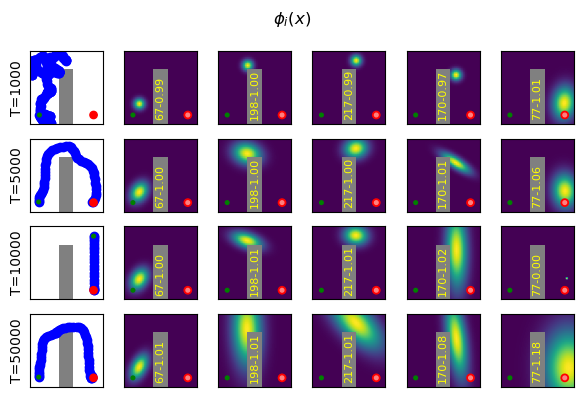

In [6]:
f,ax = plt.subplots(4,6,figsize=(6,4))
for t, trial in enumerate([1000,5000,10000,50000]):

    plot_trajectory(allcoords, trial,ax=ax[t, 0])
    plot_pc(logparams,trial, 67,ax=ax[t,1])
    plot_pc(logparams,trial, 198,ax=ax[t,2])
    plot_pc(logparams,trial, 217,ax=ax[t,3])
    plot_pc(logparams,trial, 170,ax=ax[t,4])
    plot_pc(logparams,trial, 77,ax=ax[t,5])
    ax[t,0].set_ylabel(f'T={trial}')
f.suptitle(f'$\phi_i(x)$')
f.tight_layout()
# f.savefig('./svgs/rm_2D_obs_fields_trial.svg')

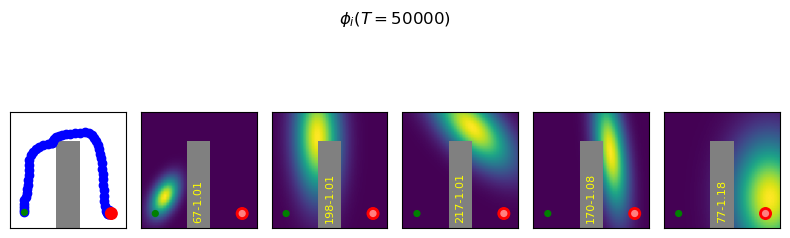

In [7]:
f,ax = plt.subplots(1,6,figsize=(8,3))

plot_trajectory(allcoords, trial,ax=ax[0])
plot_pc(logparams,trial, 67,ax=ax[1])
plot_pc(logparams,trial, 198,ax=ax[2])
plot_pc(logparams,trial, 217,ax=ax[3])
plot_pc(logparams,trial, 170,ax=ax[4])
plot_pc(logparams,trial, 77,ax=ax[5])
f.suptitle(f'$\phi_i(T={trial})$')
# f.suptitle(f'$\phi_i(x)$')
f.tight_layout()
# f.savefig('./svgs/rm_2D_obs_fields.svg')

In [8]:
def plot_sr_pc(Us, ca3, trial,pi,ax=None, goalcoord=[0.75,-0.75], startcoord=[-0.75,-0.75], goalsize=0.05, envsize=1, obs=True):
    if ax is None:
        f,ax = plt.subplots()
    
    num = 41
    ca1 = get_ca1(ca3, Us[trial])
    max_value = np.max(get_ca1(ca3, Us[0]))
    im = ax.imshow(ca1[:, pi].reshape(num, num), origin='lower', extent=[-envsize, envsize, -envsize, envsize], 
              vmin=0, vmax=max_value)
    plt.colorbar(im,ax=ax)

    start_radius = 0.05
    start_circle = plt.Circle(startcoord, start_radius, color='green', fill=True)
    ax.add_artist(start_circle)

    num_circles = 2
    for i in range(num_circles):
        radius = goalsize * (num_circles - i) / num_circles
        color = (1, i/num_circles, i/num_circles)  # RGB tuple for gradient from white to red
        circle = plt.Circle(goalcoord, radius*2, color=color, fill=True)
        ax.add_artist(circle)
    if obs:
        ax.add_patch(Rectangle((-0.2,0.5), 0.4, -1.5, facecolor='grey'))

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    ax.text(0.5, 0.05, f'{pi}-{max_value:.2f}', transform=ax.transAxes,
            fontsize=8, color='yellow', ha='center', va='bottom', rotation=90)

def relu(x):
    return np.maximum(x,0)

def get_ca1(ca3, U):
    ca1_sr = []
    for i in range(ca3.shape[0]):
        ca1_sr.append(relu(U) @ ca3[i])
    return np.array(ca1_sr)

def plot_sr_pc(Us, ca3, trial,pi,ax=None, goalcoord=[0.75,-0.75], startcoord=[-0.75,-0.75], goalsize=0.05, envsize=1, obs=True):
    if ax is None:
        f,ax = plt.subplots()
    
    num = 41
    ca1 = get_ca1(ca3, Us[trial])
    max_value = np.max(ca1[:,pi])
    ax.imshow(ca1[:, pi].reshape(num, num), origin='lower', extent=[-envsize, envsize, -envsize, envsize], 
              vmin=0, vmax=max_value)

    start_radius = 0.05
    start_circle = plt.Circle(startcoord, start_radius, color='green', fill=True)
    ax.add_artist(start_circle)

    num_circles = 2
    for i in range(num_circles):
        radius = goalsize * (num_circles - i) / num_circles
        color = (1, i/num_circles, i/num_circles)  # RGB tuple for gradient from white to red
        circle = plt.Circle(goalcoord, radius*2, color=color, fill=True)
        ax.add_artist(circle)
    if obs:
        ax.add_patch(Rectangle((-0.2,0.5), 0.4, -1.5, facecolor='grey'))

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    ax.text(0.5, 0.05, f'{pi}-{max_value:.2f}', transform=ax.transAxes,
            fontsize=8, color='yellow', ha='center', va='bottom', rotation=90)

def plot_all_sr_pc(Us, ca3, trial,goalcoord=[0.75,-0.75], startcoord=[-0.75,-0.75], goalsize=0.05, envsize=1, obs=True):
    start_radius = 0.05
    num = 41
    ca1 = get_ca1(ca3, Us[trial])

    num_curves = ca1.shape[1]
    yidx = xidx = int(num_curves**0.5)
    f,axs = plt.subplots(yidx, xidx, figsize=(12,12))
    pcidx = np.arange(num_curves)
    axs = axs.flatten()

    for i in pcidx:
        ax = axs[i]
        max_value = np.max(ca1[:,i])
        ax.imshow(ca1[:, i].reshape(num, num), origin='lower', extent=[-envsize, envsize, -envsize, envsize], 
                vmin=0, vmax=max_value)

        start_circle = plt.Circle(startcoord, start_radius, color='green', fill=True)
        ax.add_artist(start_circle)

        reward_circle = plt.Circle(goalcoord, goalsize*2, color='red', fill=True)
        ax.add_artist(reward_circle)

        ax.set_xticks([],[])
        ax.set_yticks([],[])
        ax.text(1.0, 0.0, f'{i}-{max_value:.2f}', transform=ax.transAxes,
                fontsize=6, color='yellow', ha='right')
        if obs:
            ax.add_patch(Rectangle((-0.2,0.5), 0.4, -1.5, facecolor='grey'))

    f.tight_layout()


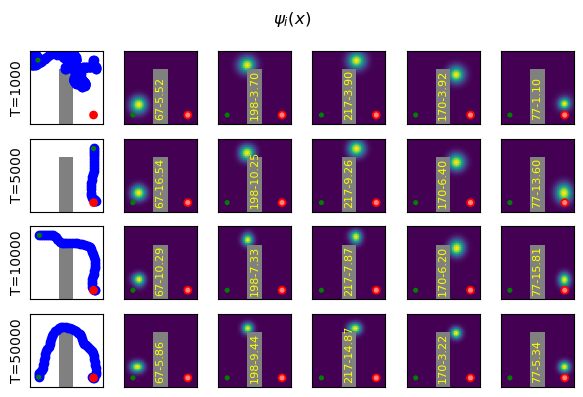

In [9]:
actual_trials = [0, 1000,5000,10000,50000]
f,ax = plt.subplots(4,6,figsize=(6,4))
for t, trial in enumerate([1,2,3,4]): #

    plot_trajectory(sr_allcoords, actual_trials[trial],ax=ax[t, 0])
    plot_sr_pc(Us, ca3,trial, 67,ax=ax[t,1])
    plot_sr_pc(Us, ca3,trial, 198,ax=ax[t,2])
    plot_sr_pc(Us, ca3,trial, 217,ax=ax[t,3])
    plot_sr_pc(Us, ca3,trial, 170,ax=ax[t,4])
    plot_sr_pc(Us, ca3,trial, 77,ax=ax[t,5])
    ax[t,0].set_ylabel(f'T={actual_trials[trial]}')
f.suptitle(f'$\psi_i(x)$')
f.tight_layout()
# f.savefig('./svgs/sr_2D_obs_fields_trial.svg')

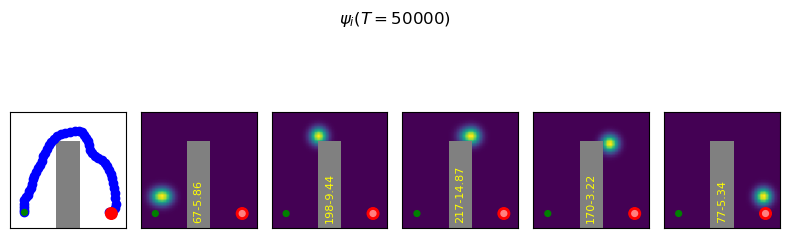

In [10]:
trial = -1
f,ax = plt.subplots(1,6,figsize=(8,3))

plot_trajectory(sr_allcoords, trial,ax=ax[0])
plot_sr_pc(Us, ca3,trial, 67,ax=ax[1])
plot_sr_pc(Us, ca3,trial, 198,ax=ax[2])
plot_sr_pc(Us, ca3,trial, 217,ax=ax[3])
plot_sr_pc(Us, ca3,trial, 170,ax=ax[4])
plot_sr_pc(Us, ca3,trial, 77,ax=ax[5])
f.suptitle(f'$\psi_i(T={50000})$')
f.tight_layout()
# f.savefig('./svgs/sr_2D_obs_fields.svg')

In [11]:
def get_field_area(logparams, trials):
    from  model import predict_batch_placecell
    areas = []
    xs = get_statespace(41)
    for trial in trials:
        ca1 = predict_batch_placecell(logparams[trial], xs)
        area = np.mean(ca1>1e-3,axis=0)
        areas.append(area)
    areas = np.array(areas)
    deltas = areas-areas[0]

    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca1.shape[1])

    return mean_deltas, sem_deltas

def get_field_center(logparams, trials,ax=None):
    from  model import predict_batch_placecell
    xs = get_statespace(41)
    ca3_init = predict_batch_placecell(logparams[0], xs)

    startcoord = [[-0.75,-0.75],[-0.75,0.75], [0.75,0.75]]

    all_delta = []
    for start in startcoord:
        deltas = []
        for trial in trials:
            ca3 = predict_batch_placecell(logparams[trial], xs)
            d = []
            for n in range(ca3.shape[1]):
                # ca3_center = xs[np.argmax(ca3[:,n])]
                orig_ca3_center = xs[np.argmax(ca3_init[:,n])]
                ca1_center = xs[np.argmax(ca3[:,n])]
                delta = ca1_center - orig_ca3_center# - ca3_center
                d.append(delta)
            deltas.append(np.array(d))
        deltas = np.array(deltas)
    
    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas

def get_sr_field_area(Us, ca3, trials):
    areas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        area = np.mean(ca1>1e-3,axis=0)
        areas.append(area)
    areas = np.array(areas)
    deltas = areas-areas[0]

    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas


def get_sr_center(Us,ca3, trials):
    ca1_init = get_ca1(ca3, Us[0])
    xs = get_statespace(41)
    deltas = []
    for trial in trials:
        ca1 = get_ca1(ca3, Us[trial])
        d = []
        for n in range(ca3.shape[1]):
            # ca3_center = xs[np.argmax(ca3[:,n])]
            orig_ca1_center = xs[np.argmax(ca1_init[:,n])]
            ca1_center = xs[np.argmax(ca1[:,n])]
            delta = ca1_center - orig_ca1_center# - ca3_center
            d.append(delta)
        deltas.append(np.array(d))
    deltas = np.array(deltas)
    mean_deltas = np.mean(deltas,axis=1)
    sem_deltas =  np.std(deltas,axis=1)/np.sqrt(ca3.shape[1])

    return mean_deltas, sem_deltas

[   50    58    66    76    87   100   115   132   151   174   200   229
   263   302   346   398   457   524   602   691   793   910  1045  1200
  1378  1582  1816  2085  2394  2748  3155  3623  4159  4775  5483  6295
  7228  8298  9528 10939 12560 14421 16557 19010 21826 25060 28772 33035
 37929 43549 50000]


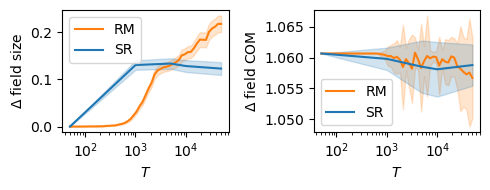

In [12]:

num = 51
gap = 50
trials = np.logspace(np.log10(gap),np.log10(50000), num,dtype=int)+1
print(trials)

sz,s = get_field_area(logparams, trials)
com,_ = get_field_center(logparams, trials)
com1 = np.linalg.norm(com-np.array([-0.75,-0.75]),axis=1,ord=2)
com2 = np.linalg.norm(com-np.array([-0.75,0.75]),axis=1,ord=2)
com3 = np.linalg.norm(com-np.array([0.75,0.75]),axis=1,ord=2)
all_com = np.concatenate([com1[:,None],com2[:,None],com3[:,None]],axis=1)
meancom = np.mean(all_com,axis=1)
stdcom = 1.96 * np.std(all_com,axis=1)/np.sqrt(3)

szsr,ssr = get_sr_field_area(Us,ca3, np.arange(5))
comsr,_ = get_sr_center(Us,ca3, np.arange(5))
comsr1 = np.linalg.norm(comsr-np.array([-0.75,-0.75]),axis=1,ord=2)
comsr2 = np.linalg.norm(comsr-np.array([-0.75,0.75]),axis=1,ord=2)
comsr3 = np.linalg.norm(comsr-np.array([0.75,0.75]),axis=1,ord=2)
all_comsr = np.concatenate([comsr1[:,None],comsr2[:,None],comsr3[:,None]],axis=1)
meancomsr = np.mean(all_comsr,axis=1)
stdcomsr = 1.96 * np.std(all_comsr,axis=1)/np.sqrt(3)


actual_trials = [50, 1000,5000,10000,50000]
f,(ax1,ax2)= plt.subplots(1,2,figsize=(5,2))

ax1.plot(trials, sz, color='tab:orange',label='RM')
ax1.fill_between(x=trials, y1=sz-s, y2=sz+ s,alpha=0.2, color='tab:orange',)
ax1.plot(actual_trials, szsr, color='tab:blue',label='SR')
ax1.fill_between(x=actual_trials, y1=szsr-ssr, y2=szsr+ ssr,alpha=0.2, color='tab:blue',)
ax1.set_xscale('log')
ax1.set_ylabel('$\Delta$ field size')
ax1.legend()
ax1.set_xlabel('$T$')
ax2.plot(trials, meancom, color='tab:orange',label='RM')
ax2.fill_between(x=trials, y1=meancom-stdcom, y2=meancom+ stdcom,alpha=0.2, color='tab:orange',)
ax2.plot(actual_trials, meancomsr, color='tab:blue',label='SR')
ax2.fill_between(x=actual_trials, y1=meancomsr-stdcomsr, y2=meancomsr+ stdcomsr,alpha=0.2, color='tab:blue',)
ax2.set_xscale('log')
ax2.set_ylabel('$\Delta$ field COM')
ax2.legend()
ax2.set_xlabel('$T$')

# f.suptitle('Change in field selectivity in 2D with SR and RM agents')
f.tight_layout()
# f.savefig('./svgs/2D_com_size.svg')